In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

plt.ioff()

In [12]:
# Each figure created below is given a unique number, so we 
# can save each one to disk and iterate through them later.
fignum = 1
# The location of the saved figures
tmpdir = "/tmp/mpl"

In [3]:
%%bash -s "$tmpdir"

if [ -d "$1" ]
then 
    rm -rf "$1"
fi
mkdir "$1"

In [4]:
plt.get_fignums()

[]

In [5]:
# Current indentation level (i.e., how deep in the call stack we are)
level = 0
# Global variable to keep track of the current line number
line = 0

# Wraps a function in a function that prints our call information
def logger(fn):
    def wrapper(*args, **kwargs):
        # Create the padding string according to the current level in the call
        # stack, and increase the level since we're about to pop another 
        # function onto the stack.
        global level, line
        padding = "|" + "-" * (level * 4 - 1) if level > 0 else ""
        level += 1

        # Print calling information, call the function, and print returning info
        line += 1
        print "%2d. %sCalling %s.%s" % (line, padding, fn.__module__, fn.__name__)
        result = fn(*args, **kwargs)
        line += 1
        print "%2d. %sReturning <%s:%s> from %s.%s" % \
            (line, padding, result.__class__.__name__, id(result), fn.__module__, fn.__name__)
        
        # Decrease the call stack level, since we are returning.
        level -= 1
        return result
    return wrapper
    
# Decorate several methods with the logger function
plt.gca = logger(plt.gca)
plt.gcf = logger(plt.gcf)
plt.figure = logger(plt.figure)
plt.close = logger(plt.close)
from matplotlib.figure import Figure
Figure.gca = logger(Figure.gca)
Figure.add_subplot = logger(Figure.add_subplot)

In [6]:
plt.hist(np.random.randn(1000))
plt.savefig('%s/%d.png' % (tmpdir, fignum))
fignum += 1
line = 0

 1. Calling matplotlib.pyplot.gca
 2. |---Calling matplotlib.pyplot.gcf
 3. |-------Calling matplotlib.pyplot.figure
 4. |-------Returning <Figure:4360922960> from matplotlib.pyplot.figure
 5. |---Returning <Figure:4360922960> from matplotlib.pyplot.gcf
 6. |---Calling matplotlib.figure.gca
 7. |-------Calling matplotlib.figure.add_subplot
 8. |-------Returning <AxesSubplot:4387128784> from matplotlib.figure.add_subplot
 9. |---Returning <AxesSubplot:4387128784> from matplotlib.figure.gca
10. Returning <AxesSubplot:4387128784> from matplotlib.pyplot.gca
11. Calling matplotlib.pyplot.gcf
12. Returning <Figure:4360922960> from matplotlib.pyplot.gcf


In [7]:
plt.get_fignums()

[1]

The interactive backends (UI and Jupyter notebook), the `_pylab_helpers.destroy` function is called once the figure is shown. So, we end up with only 1 active figure in the queue at all times. However, when rendering a hardcopy the figure is not destroyed, and so calling any plot command will simply add to the current figure. There are two ways to prevent this from happening: first, you can call the `plt.clf()` function to clear the current figure before you reuse it, second, you can call the `plt.figure()` function to create a new figure.

In [8]:
plt.clf()
line = 0

 1. Calling matplotlib.pyplot.gcf
 2. Returning <Figure:4360922960> from matplotlib.pyplot.gcf


In [9]:
plt.plot(np.random.randn(100))
plt.savefig('%s/%d.png' % (tmpdir, fignum))
line = 0

 1. Calling matplotlib.pyplot.gca
 2. |---Calling matplotlib.pyplot.gcf
 3. |---Returning <Figure:4360922960> from matplotlib.pyplot.gcf
 4. |---Calling matplotlib.figure.gca
 5. |-------Calling matplotlib.figure.add_subplot
 6. |-------Returning <AxesSubplot:4388325776> from matplotlib.figure.add_subplot
 7. |---Returning <AxesSubplot:4388325776> from matplotlib.figure.gca
 8. Returning <AxesSubplot:4388325776> from matplotlib.pyplot.gca
 9. Calling matplotlib.pyplot.gcf
10. Returning <Figure:4360922960> from matplotlib.pyplot.gcf


In [10]:
plt.get_fignums()

[1]

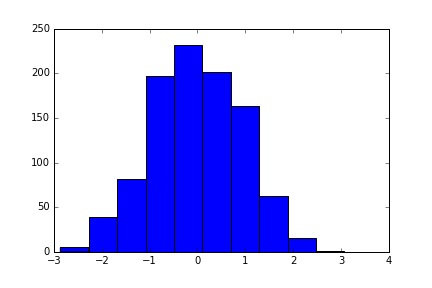

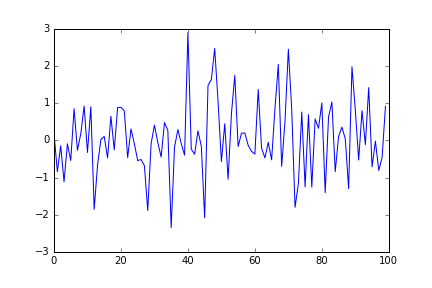

In [11]:
from IPython.display import Image, display_png
images = !ls /tmp/mpl/*.png
for img_fname in images:
    display_png(Image(filename=img_fname))

## Memory Management

In [ ]:
import warnings
warnings.simplefilter(action="always", category=RuntimeWarning)

In [ ]:
for i in range(21):
    plt.figure()
    plt.hist(np.random.randn(1000))

In [ ]:
plt.get_fignums()

### Why does this happen?

By default, the `pylot` plotting functions do not close figures as they're used. Instead, `pyplot` registers an event listener that destroys all figures in memory when your script comes to an end. While the script is running, however, the `pyplot` interface does actively manage memory by reusing a single figure over and over again. Basically, every time a figure is rendered (output to a file or displayed in a window) `pyplot` will clear the figure and reuse it for the next set of plotting commands. It grabs the current figure from the top of global stack, and it always checks the stack for a figure before it creates a new one. If the user calls the `figure` function directly, they bypass this check and create a new figure and add it to the top of the stack, and `pyplot` just uses that whenever plotting commands are called. This means that each time the figure 

In [ ]:
plt.close("all")

In [ ]:
for i in range(21):
    plt.figure()
    plt.hist(np.random.randn(1000))
    plt.show()
    #plt.close()

Now we no longer get a warning because we are closing each figure manually after we're finished with it.

In [ ]:
plt.get_fignums()